### You will use:
* the simple simulation Python code from the first couple of weeks
* the correlation matrix in the Excel workbook Expected Returns BL Shrinkage Estimator.xlsx, tab "Layer Covariance Matrix", cells B30:B36 for standard deviations and C30:I36 for correlations
* the expected returns in column 2021* for expected returns in the Northern Trust PDF

How to map the asset classes (please use the Northern Trust labels in your report):
Covariance --> Northern Trust
Large Cap Stocks > Developed market equities
Small Cap Stocks > Emerging market equities
Gov Bond > US Inflation linked
IG Credit Bond > US investment grade
HY Credit Bond > US high yield
Real Estate > Listed real estate
Cash > Cash

Use the cash flows (in and out of the account) already in the Python code.

Assume that your boss asks you to run a simulation with a sensitivity analysis:
* what happens if during the accumulation phase (young, contributing to account) the allocation is 55 stocks / 30 bonds (you decide how to break it down, and always put 5% in real estate) or 85 stocks / 10 bonds? This is a sensitivity analysis on asset allocation
* what happens if the person increases the contributions while young by 10,000 and the withdrawals when old by 20,000? this is a sensitivity analysis on cash flows
* what happens if you use the 2015 expected returns on the base case? This is a sensitivity analysis on expected returns

Please present the case with the assumptions (do not show the covariance matrix or Python code) in a clear report of 5-7 pages. Remember that the person for whom you write it is an MBA and not a finance or econometrics expert.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.max_rows=400
pd.options.display.float_format = '{:,.3f}'.format

In [2]:
df_data = pd.read_excel("Northern Trust Asset Management Data.xlsx",sheet_name="Data")
df_stats= pd.read_excel("Northern Trust Asset Management Data.xlsx",sheet_name="STD").sort_values("Asset Type").reset_index(
    drop=True)
df_corr= pd.read_excel("Northern Trust Asset Management Data.xlsx",sheet_name="Correlation")
#df_cov= pd.read_excel("Northern Trust Asset Management Data.xlsx",sheet_name="Covariance").sort_values("index").set_index("index")
df_cashflow=pd.read_excel("Northern Trust Asset Management Data.xlsx",sheet_name="Cashflow")

In [3]:
###  Large Cap Stocks > Developed market equities
df_data.loc[(df_data["Asset Class1"]=="Equities")&
       (df_data["Asset Class2"]=="Developed markets") &
       (df_data["Asset Class3"]=="U.S."),"Asset Type"]="Large Cap Stocks"

###  Small Cap Stocks > Emerging market equities
df_data.loc[(df_data["Asset Class1"]=="Equities")&
       (df_data["Asset Class2"]=="Emerg. markets") &
       (df_data["Asset Class3"]=="Emerging markets"),
           "Asset Type"]="Small Cap Stocks"

###  Gov Bond > US Inflation linked 
df_data.loc[(df_data["Asset Class2"]=="USA")&
       (df_data["Asset Class3"]=="Inflation linked"),
       "Asset Type"]="Gov Bond"

###  IG Credit Bond > US investment grade
df_data.loc[(df_data["Asset Class2"]=="USA")&
       (df_data["Asset Class3"]=="Investment grade"),
       "Asset Type"]="IG Credit Bond"


###  HY Credit Bond > US high yield
df_data.loc[(df_data["Asset Class2"]=="USA")&
       (df_data["Asset Class3"]=="High yield"),
                         "Asset Type"]="HY Credit Bond"

### Real Estate > Listed real estate
df_data.loc[(df_data["Asset Class1"]=="Real")&
       (df_data["Asset Class3"]=="Listed real estate"),"Asset Type"]="Real Estate"

### Cash > Cash
df_data.loc[(df_data["Asset Class1"]=="Fixed Income")&
       (df_data["Asset Class2"]=="USA") &
       (df_data["Asset Class3"]=="Cash"),"Asset Type"]="Cash"

df_data.sort_values("Asset Type",inplace=True)

In [4]:
### Filter on the specified assets
df_data=df_data[~df_data["Asset Type"].isnull()]

### Merge the Sandard Deviation of each asset
df_data=pd.merge(df_data,
         df_stats[['Asset Type','SD']],
         left_on="Asset Type",
         right_on="Asset Type",
         how="left")

In [5]:
df_data=pd.merge(df_data.reset_index(),
             df_corr.rename(columns={"index":"Asset Type"}).reset_index().rename(columns={"index":"Order"})[["Asset Type","Order"]],
             left_on="Asset Type",
             right_on="Asset Type",
             how="left").sort_values("Order").drop("index",axis=1)

df_corr=df_corr.set_index("index")

In [8]:
df_corr

,Large Cap Stocks,Small Cap Stocks,Gov Bond,IG Credit Bond,HY Credit Bond,Real Estate,Cash
index,,,,,,,
Large Cap Stocks,1.000,0.840,0.338,0.586,0.754,0.750,0.100
Small Cap Stocks,0.840,1.000,0.299,0.552,0.794,0.820,0.495
Gov Bond,0.338,0.299,1.000,0.846,0.806,0.765,0.630
IG Credit Bond,0.586,0.552,0.846,1.000,0.830,0.840,0.676
HY Credit Bond,0.754,0.794,0.806,0.830,1.000,0.850,0.691
Real Estate,0.750,0.820,0.765,0.840,0.850,1.000,0.736
Cash,0.100,0.495,0.630,0.676,0.691,0.736,1.000


### replicates covariance from correlation matrix

In [9]:
SD=df_data["SD"].values.reshape(-1,1)
CorrMat= df_corr.values
# Compute the covariance matrix
OuterProduct = np.dot(SD,SD.T)
CovMat=CorrMat*OuterProduct

In [10]:
asset_allocation_young={"Large Cap Stocks":.300,
                       "Small Cap Stocks":.450,
                       "Gov Bond":.050,
                       "IG Credit Bond":.050,
                       "HY Credit Bond":.050,
                       "Real Estate":.050,
                       "Cash":.050}


asset_allocation_old={"Large Cap Stocks":.35,
                       "Small Cap Stocks":.1,
                       "Gov Bond":.15,
                       "IG Credit Bond":.15,
                       "HY Credit Bond":.15,
                       "Real Estate":.05,
                       "Cash":.05}

In [11]:
ExpRet_2021=(df_data[2021]/100).values.reshape(-1,1)
number_of_assets=len(ExpRet_2021)

# Define the remaining life of this person
Total_years=60
Retire_in_years = 30
retierment_period= Total_years - Retire_in_years
Number_of_simulation=1000

In [12]:
def multi_variate_portfolio_return_computer(expected_return,
                                 covariance,
                                 number_of_years,
                                 NumSim,
                                 list_of_asset_allocation):
    import numpy as np
    simulated_multivariate_return = np.random.multivariate_normal(
        expected_return,
        covariance,
        (number_of_years,NumSim))

    simulated_portfoli_return = simulated_multivariate_return @ np.array(list_of_asset_allocation)
    return simulated_portfoli_return

### Generate Returns

In [13]:
portfolio_return_during_younghood = multi_variate_portfolio_return_computer(ExpRet_2021.flatten(),
                                       CovMat,
                                       Retire_in_years,
                                       Number_of_simulation,
                                       list(asset_allocation_young.values()))

portfolio_return_during_oldhood = multi_variate_portfolio_return_computer(ExpRet_2021.flatten(),
                                       CovMat,
                                       retierment_period,
                                       Number_of_simulation,
                                       list(asset_allocation_old.values()))

C:\Users\fbaharkoush\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: covariance is not positive-semidefinite.
  # Remove the CWD from sys.path while we load stuff.


### Case 1
initial_contribution=100000

yearly_contribution=10000

yearly_withdraw=-20000



In [19]:
### Case 1
initial_contribution=100000
yearly_contribution=10000
yearly_withdraw=-20000

In [20]:
portfolio_return=np.concatenate((portfolio_return_during_younghood,
               portfolio_return_during_oldhood))

In [26]:
### Earch Column Represnet one possible scenarios in 60 years
df_portfolio=pd.DataFrame(portfolio_return)
df_portfolio=pd.merge(df_portfolio.reset_index().rename(columns={"index":"Year"}),
         df_cashflow,
         left_on="Year",
         right_on="Year",
         how="left")
df_portfolio

,Year,0,1,2,3,4,5,6,7,8,...,992,993,994,995,996,997,998,999,Contribution,Withdraw
0,0,0.075,0.235,-0.084,0.007,-0.017,0.057,-0.095,0.111,-0.018,...,0.155,0.080,-0.001,0.083,0.134,0.010,-0.052,0.071,initial,0
1,1,0.037,0.064,0.044,0.027,0.140,0.071,-0.066,0.104,-0.064,...,-0.000,-0.111,0.082,0.108,0.042,0.040,0.072,0.048,1,0
2,2,-0.041,0.248,-0.012,0.197,0.059,0.237,0.109,0.095,0.087,...,-0.024,-0.036,0.182,0.048,0.083,0.029,0.164,0.052,1,0
3,3,0.049,-0.030,-0.024,-0.004,0.072,0.094,0.154,-0.152,-0.081,...,-0.024,0.004,0.010,0.100,-0.043,0.020,0.070,0.069,1,0
4,4,-0.008,0.153,0.132,0.105,-0.002,0.059,0.059,0.004,0.087,...,0.082,-0.044,0.049,-0.121,0.079,0.089,0.054,-0.061,1,0
5,5,0.009,-0.041,0.144,0.005,-0.094,0.139,0.087,0.058,-0.041,...,0.062,0.073,-0.044,0.014,-0.020,0.082,0.059,0.021,1,0
6,6,-0.005,-0.002,0.127,0.040,-0.046,-0.015,-0.042,0.020,0.028,...,0.044,0.038,0.115,0.008,0.041,0.092,0.082,0.140,1,0
7,7,0.076,0.151,-0.045,0.117,0.047,0.096,0.063,-0.004,0.052,...,0.048,0.050,0.047,0.023,0.118,0.034,0.021,0.143,1,0
8,8,-0.008,0.005,0.064,0.055,0.081,0.126,0.050,0.064,0.052,...,-0.099,0.078,-0.020,-0.048,0.106,0.022,-0.015,-0.110,1,0
9,9,0.074,0.012,-0.048,0.087,0.080,0.034,0.098,0.097,0.075,...,0.024,-0.025,0.041,0.168,0.046,0.023,0.009,0.089,1,0


In [27]:
df_portfolio.loc[df_portfolio["Contribution"]=="initial",
                "Contribution"]=initial_contribution

df_portfolio.loc[df_portfolio["Contribution"]==1,
                "Contribution"]=yearly_contribution



df_portfolio.loc[df_portfolio["Withdraw"]==1,
                "Withdraw"]=yearly_withdraw

In [28]:
df_portfolio

,Year,0,1,2,3,4,5,6,7,8,...,992,993,994,995,996,997,998,999,Contribution,Withdraw
0,0,0.075,0.235,-0.084,0.007,-0.017,0.057,-0.095,0.111,-0.018,...,0.155,0.080,-0.001,0.083,0.134,0.010,-0.052,0.071,100000,0
1,1,0.037,0.064,0.044,0.027,0.140,0.071,-0.066,0.104,-0.064,...,-0.000,-0.111,0.082,0.108,0.042,0.040,0.072,0.048,10000,0
2,2,-0.041,0.248,-0.012,0.197,0.059,0.237,0.109,0.095,0.087,...,-0.024,-0.036,0.182,0.048,0.083,0.029,0.164,0.052,10000,0
3,3,0.049,-0.030,-0.024,-0.004,0.072,0.094,0.154,-0.152,-0.081,...,-0.024,0.004,0.010,0.100,-0.043,0.020,0.070,0.069,10000,0
4,4,-0.008,0.153,0.132,0.105,-0.002,0.059,0.059,0.004,0.087,...,0.082,-0.044,0.049,-0.121,0.079,0.089,0.054,-0.061,10000,0
5,5,0.009,-0.041,0.144,0.005,-0.094,0.139,0.087,0.058,-0.041,...,0.062,0.073,-0.044,0.014,-0.020,0.082,0.059,0.021,10000,0
6,6,-0.005,-0.002,0.127,0.040,-0.046,-0.015,-0.042,0.020,0.028,...,0.044,0.038,0.115,0.008,0.041,0.092,0.082,0.140,10000,0
7,7,0.076,0.151,-0.045,0.117,0.047,0.096,0.063,-0.004,0.052,...,0.048,0.050,0.047,0.023,0.118,0.034,0.021,0.143,10000,0
8,8,-0.008,0.005,0.064,0.055,0.081,0.126,0.050,0.064,0.052,...,-0.099,0.078,-0.020,-0.048,0.106,0.022,-0.015,-0.110,10000,0
9,9,0.074,0.012,-0.048,0.087,0.080,0.034,0.098,0.097,0.075,...,0.024,-0.025,0.041,0.168,0.046,0.023,0.009,0.089,10000,0


In [15]:
list_of_simulation_df_values=[]
for simulation in list(df_portfolio.drop(["Year","Contribution","Withdraw"],axis=1).columns):
    df_portfolio["Value"] = df_portfolio["Contribution"]*(1+df_portfolio[simulation])
    for i in range(1,len(df_portfolio)):
        df_portfolio.loc[i,"Value"] = ((df_portfolio.loc[i-1,"Value"] * (1+df_portfolio.loc[i,simulation])) +
                                       ((df_portfolio.loc[i,"Contribution"]) * (1+df_portfolio.loc[i,simulation]))+
                                       df_portfolio.loc[i,"Withdraw"])
    list_of_simulation_df_values.append(df_portfolio[["Value","Year"]])

In [16]:
df_simulation_result= pd.concat(list_of_simulation_df_values)

initial contribution: 100000 yearly contribution: 10000 yearly withdraw: -20000


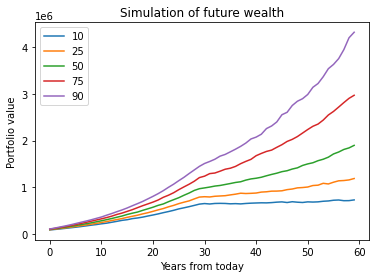

In [17]:
pd.DataFrame(list(df_simulation_result.groupby("Year")['Value'].apply(
    lambda x: np.percentile(x,[10,25,50,75,90]))),
            columns=[10,25,50,75,90]).reset_index().rename(columns={"index":"Year"}).set_index("Year").plot()
print("initial contribution:",initial_contribution,
      "yearly contribution:",yearly_contribution,
      "yearly withdraw:",yearly_withdraw)
plt.title('Simulation of future wealth')
plt.xlabel('Years from today')
plt.ylabel('Portfolio value')
plt.legend()
plt.show()

### Case 2
initial_contribution=100000

yearly_contribution=20000

yearly_withdraw=-30000


In [18]:
initial_contribution=100000
yearly_contribution=20000
yearly_withdraw=-30000

In [19]:
portfolio_return=np.concatenate((portfolio_return_during_younghood,
               portfolio_return_during_oldhood))

df_portfolio=pd.DataFrame(portfolio_return)
df_portfolio=pd.merge(df_portfolio.reset_index().rename(columns={"index":"Year"}),
         df_cashflow,
         left_on="Year",
         right_on="Year",
         how="left")

In [20]:
df_portfolio.loc[df_portfolio["Contribution"]=="initial",
                "Contribution"]=initial_contribution

df_portfolio.loc[df_portfolio["Contribution"]==1,
                "Contribution"]=yearly_contribution



df_portfolio.loc[df_portfolio["Withdraw"]==1,
                "Withdraw"]=yearly_withdraw

In [21]:
list_of_simulation_df_values=[]
for simulation in list(df_portfolio.drop(["Year","Contribution","Withdraw"],axis=1).columns):
    df_portfolio["Value"] = df_portfolio["Contribution"]*(1+df_portfolio[simulation])
    for i in range(1,len(df_portfolio)):
        df_portfolio.loc[i,"Value"] = ((df_portfolio.loc[i-1,"Value"] * (1+df_portfolio.loc[i,simulation])) +
                                       ((df_portfolio.loc[i,"Contribution"]) * (1+df_portfolio.loc[i,simulation]))+
                                       df_portfolio.loc[i,"Withdraw"])
    list_of_simulation_df_values.append(df_portfolio[["Value","Year"]])

df_simulation_result= pd.concat(list_of_simulation_df_values)

initial contribution: 100000 yearly contribution: 20000 yearly withdraw: -30000


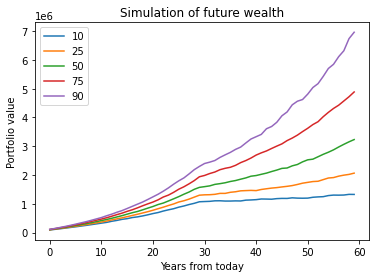

In [22]:
pd.DataFrame(list(df_simulation_result.groupby("Year")['Value'].apply(
    lambda x: np.percentile(x,[10,25,50,75,90]))),
            columns=[10,25,50,75,90]).reset_index().rename(columns={"index":"Year"}).set_index("Year").plot()

print("initial contribution:",initial_contribution,
      "yearly contribution:",yearly_contribution,
      "yearly withdraw:",yearly_withdraw)
plt.title('Simulation of future wealth')
plt.xlabel('Years from today')
plt.ylabel('Portfolio value')
plt.legend()
plt.show()